# I am adding markdown to this because I am beginning to forget how this works

This program creates graphs of how often different classifiers predict good values at different randomness amplitudes for the test values. The first graph shows curves for each classiifer, while the other graphs graph a line from each randomness amplitude with the color depicting it's percentage of accuracy.

In [1]:
import numpy as np
from sklearn.externals import joblib
import copy
import random
import math
import matplotlib as mp
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.base import clone
from sklearn import metrics
from __future__ import unicode_literals

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [3]:
mp.rcParams.update({'font.size': 16})

In [4]:
datadict = joblib.load("Two_Port_Standard_Dictionary_Cleaned_Interpolated.pkl")

In [5]:
num_fake_points = 15000
magS11_deviation = 0.003
magS21_deviation = 0.0001
magS22_deviation = 0.003
frequency_range = np.linspace(2,18,50)

In [6]:
magS11_points = []
magS21_points = []
magS22_points = []
for i in range(num_fake_points):
    new_dataset = copy.deepcopy(datadict['CTN210']['System 2,7'][random.choice(datadict['CTN210']['System 2,7'].keys())])
    new_dataset["magS11"] += np.random.normal(0,magS11_deviation,50)
    new_dataset["magS21"] += np.random.normal(0,magS21_deviation,50)
    new_dataset["magS22"] += np.random.normal(0,magS22_deviation,50)
    magS11_points.append(new_dataset["magS11"].tolist())
    magS21_points.append(new_dataset["magS21"].tolist())
    magS22_points.append(new_dataset["magS22"].tolist())
magS11_arr = np.array(magS11_points)
magS21_arr = np.array(magS21_points)
magS22_arr = np.array(magS22_points)

In [7]:
names = ["Gaussian Naive Bayes",
         "Decision Tree",
         "Random Forest",
         "Quadratic Discriminant Analysis",
         "Voting"]
classifiers = [GaussianNB(),
               DecisionTreeClassifier(),
               RandomForestClassifier(),
               QuadraticDiscriminantAnalysis(),
               VotingClassifier(estimators=[
                   ('gnb',GaussianNB()),
                   ('rf',RandomForestClassifier()),
                   ('dt',DecisionTreeClassifier()),
                   ('qda',QuadraticDiscriminantAnalysis())
               ],voting="soft")]

In [8]:
def get_trained_classifier(randomness_amplitude,untrained_classifier):
    incorrect_magS21_data = copy.deepcopy(magS21_arr)
    for i in range(len(incorrect_magS21_data)):
        incorrect_magS21_data[i] = (incorrect_magS21_data[i] + np.random.normal(0,randomness_amplitude,50))
    #Making training and test data
    S21_training_data = []
    S21_training_data.extend(incorrect_magS21_data.tolist())
    S21_training_data.extend(magS21_arr.tolist())
    S21_training_data_arr = np.array(S21_training_data)
    targets = ["Bad","Good"]
    S21_target_arr = np.repeat(targets,len(magS21_arr))
    S21_training_data_arr,S21_target_arr = shuffle(S21_training_data_arr,S21_target_arr, random_state=0)
    #Cloning and Training Classifier
    clf = clone(untrained_classifier)
    clf.fit(S21_training_data_arr,S21_target_arr)
    return clf

In [9]:
def get_test_data_predict_correct_percent(randomness_amplitude,trained_classifier):
    test_data = copy.deepcopy(magS21_arr)
    for i in range(len(test_data)):
        test_data[i] = test_data[i] + np.random.normal(0,randomness_amplitude,50)
    predicted = trained_classifier.predict(test_data)
    num_good_points = 0
    for index in range(len(predicted)):
        if predicted[index] == "Good":
            num_good_points += 1
    return (num_good_points/float(len(predicted)))*100.0

In [10]:
randomness_amp = 0.001
num_test_amplitudes = 50
test_amplitude_min = 0
test_amplitude_max = 0.0015

In [11]:
results_dict = {}
test_amplitudes = np.linspace(test_amplitude_min,test_amplitude_max,num_test_amplitudes)
for index in range(len(classifiers)):
    trained_classifier = get_trained_classifier(randomness_amp,classifiers[index])
    results_dict[names[index]] = []
    for amp in test_amplitudes:
        test_data_predict_correct_percent = get_test_data_predict_correct_percent(amp,trained_classifier)
        results_dict[names[index]].append(test_data_predict_correct_percent)
    print "Finished a Classifier!"
print "Done!"

Finished a Classifier!
Finished a Classifier!
Finished a Classifier!
Finished a Classifier!
Finished a Classifier!
Done!


In [12]:
print results_dict["Random Forest"]

[99.99333333333334, 99.98666666666666, 99.62666666666667, 98.12666666666667, 93.12, 81.89333333333333, 64.86, 47.49333333333333, 31.993333333333336, 20.006666666666668, 11.98, 6.886666666666668, 4.3, 2.3, 1.3466666666666667, 0.66, 0.45333333333333337, 0.26666666666666666, 0.12, 0.11333333333333334, 0.05333333333333334, 0.02666666666666667, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


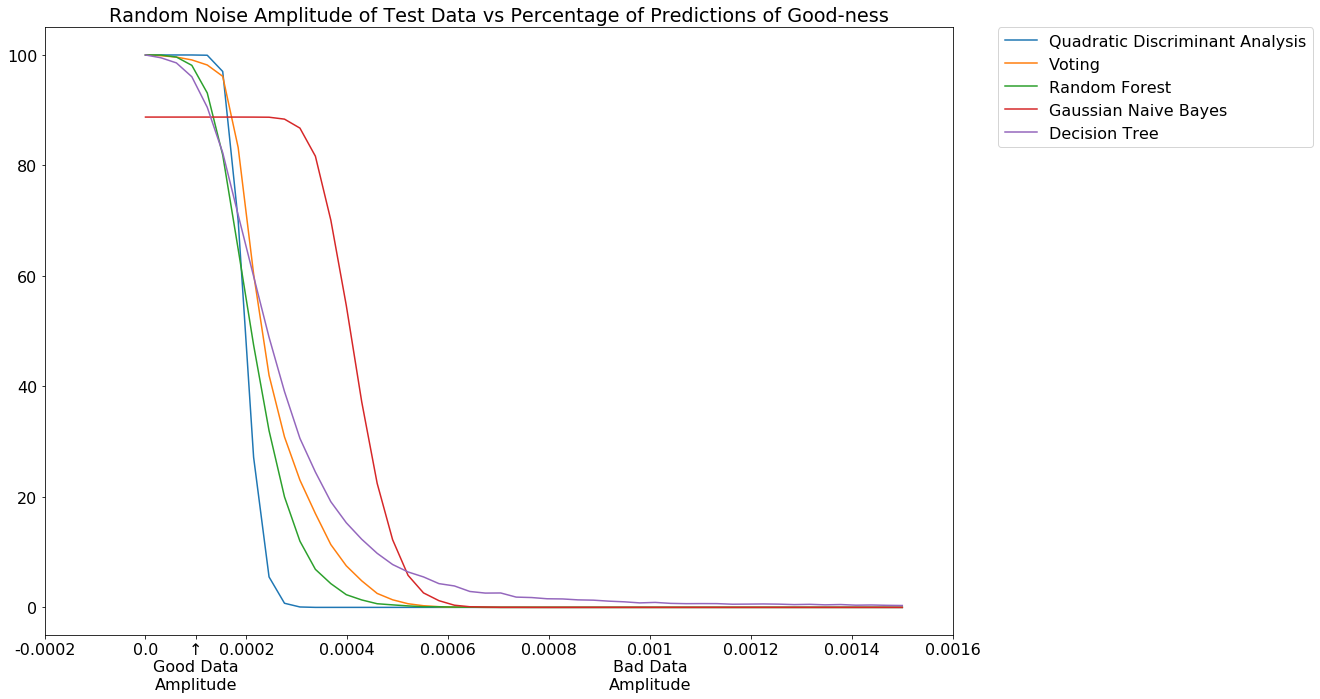

In [13]:
label_handles = []
plt.figure(figsize=(14,10))
for key in results_dict.keys():
    label_handles.extend(plt.plot(test_amplitudes,results_dict[key],label=key))
ax = plt.gca()
ax.set_xticks(list(ax.get_xticks()) + [magS21_deviation])
labels = ax.get_xticks()
labels2 = [str(x) for x in labels]
labels2[10] = "↑\nGood Data\nAmplitude"
labels2[6] = "0.001\nBad Data\nAmplitude"
ax.set_xticklabels(labels2)
plt.legend(handles=label_handles,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Random Noise Amplitude of Test Data vs Percentage of Predictions of Good-ness")
plt.tight_layout()
plt.show()

In [14]:
def get_test_data_predict_correct_info(randomness_amplitude,trained_classifier):
    test_data = copy.deepcopy(magS21_arr)
    for i in range(len(test_data)):
        test_data[i] = test_data[i] + np.random.normal(0,randomness_amplitude,50)
    predicted = trained_classifier.predict(test_data)
    num_good_points = 0
    for index in range(len(predicted)):
        if predicted[index] == "Good":
            num_good_points += 1
    return ((num_good_points/float(len(predicted))),test_data[:50])

In [15]:
results_dict_more_info = {}
test_amplitudes = np.linspace(test_amplitude_min,test_amplitude_max,num_test_amplitudes)
for index in range(len(classifiers)):
    trained_classifier = get_trained_classifier(randomness_amp,classifiers[index])
    results_dict_more_info[names[index]] = []
    for amp in test_amplitudes:
        test_data_predict_correct_info = get_test_data_predict_correct_info(amp,trained_classifier)
        results_dict_more_info[names[index]].append(test_data_predict_correct_info)
    print "Finished a Classifier!"
print "Done!"

Finished a Classifier!
Finished a Classifier!
Finished a Classifier!
Finished a Classifier!
Finished a Classifier!
Done!


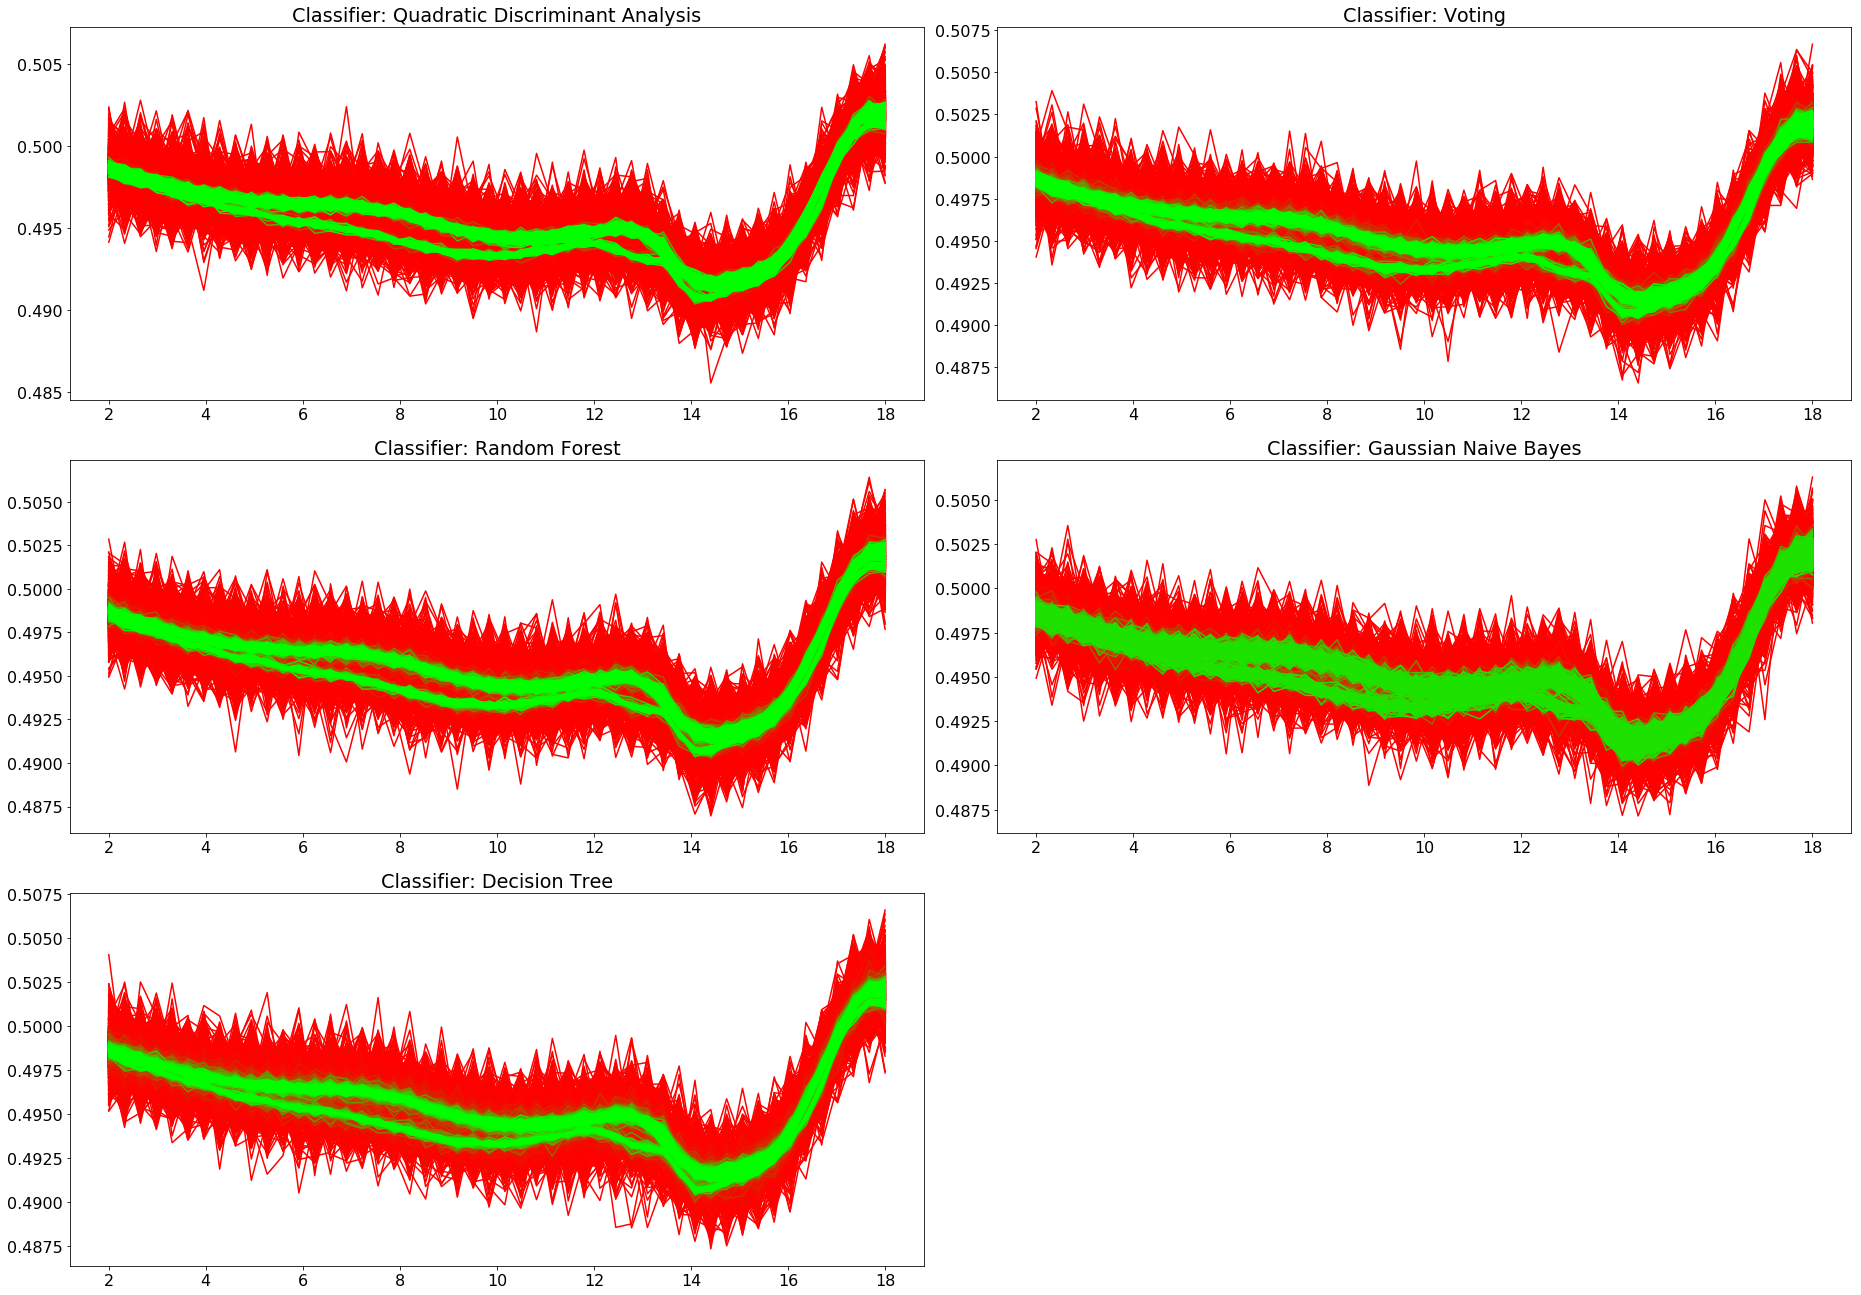

In [16]:
import matplotlib.colors as mpc
plt.figure(figsize=(13*2,15*2))
for index,key in enumerate(results_dict_more_info.keys()):
    plt.subplot(len(results_dict_more_info.keys()),2,index+1)
    plt.title("Classifier: " + key)
    for z_value,linedata in enumerate(reversed(results_dict_more_info[key])):
        linecolor=(1-linedata[0],linedata[0],0)
        for i in range(len(linedata[1])):
            plt.plot(frequency_range,linedata[1][i],color=linecolor,zorder=z_value)
plt.tight_layout()
plt.show()

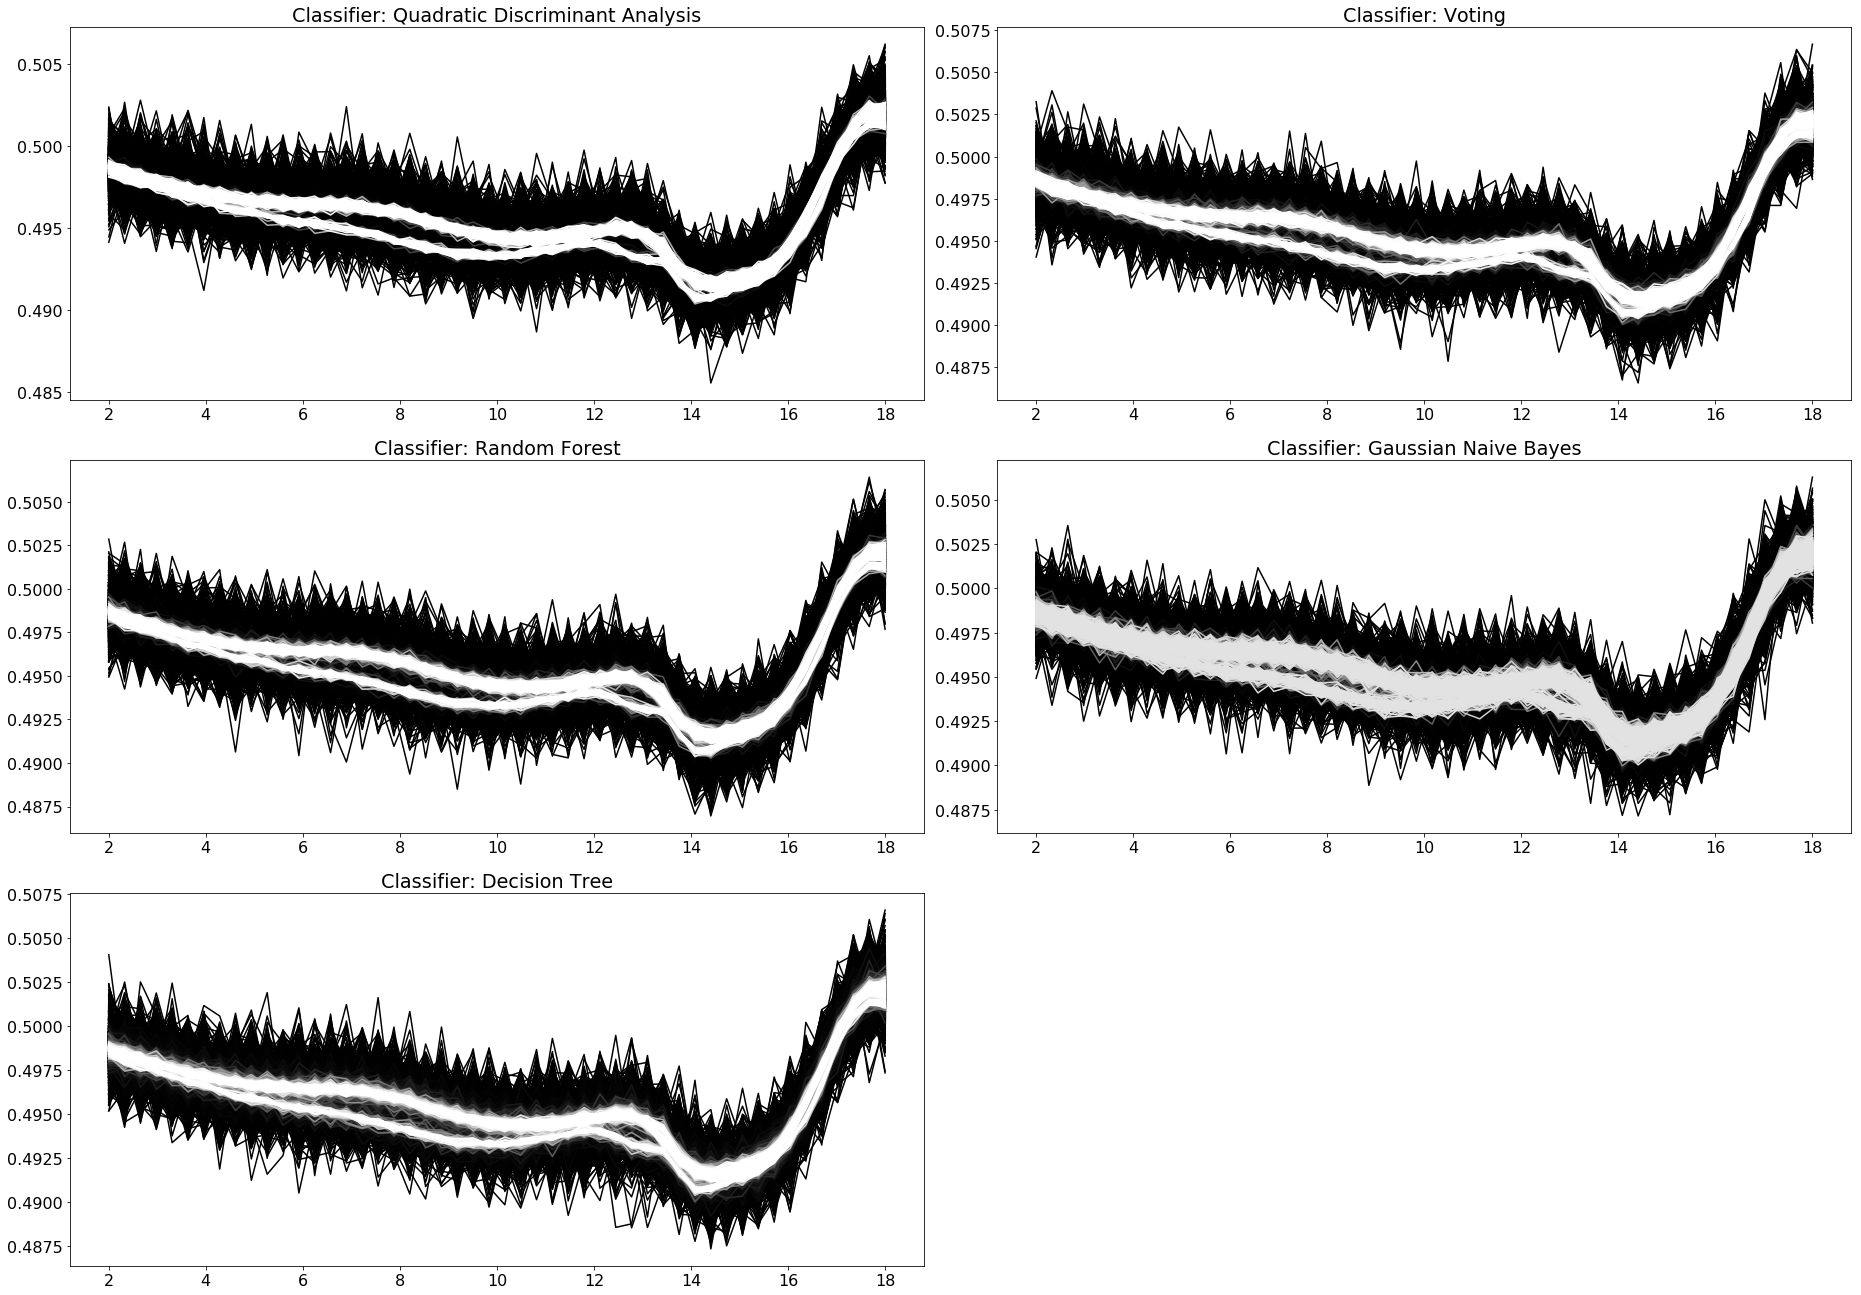

In [18]:
import matplotlib.colors as mpc
plt.figure(figsize=(13*2,15*2))
for index,key in enumerate(results_dict_more_info.keys()):
    plt.subplot(len(results_dict_more_info.keys()),2,index+1)
    plt.title("Classifier: " + key)
    for z_value,linedata in enumerate(reversed(results_dict_more_info[key])):
        linecolor=(linedata[0],linedata[0],linedata[0])
        for i in range(len(linedata[1])):
            plt.plot(frequency_range,linedata[1][i],color=linecolor,zorder=z_value)
plt.tight_layout()
plt.show()